In [1]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import pickle
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
%load_ext watermark

2025-04-13 18:17:40.450170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744543060.463314   60689 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744543060.467058   60689 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744543060.476637   60689 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744543060.476656   60689 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744543060.476658   60689 computation_placer.cc:177] computation placer alr

In [2]:
# Load both datasets
student_chatgpt = pd.read_excel("example_datasets/examples-datasets-mar25.xlsx")
only_chatgpt = pd.read_excel("example_datasets/knowledge-datasets-mar25.xlsx")

In [3]:
# Tampilkan informasi dataset
print("Dataset Student_ChatGPT:")
print(student_chatgpt.info())
print("\nDataset Only_ChatGPT:")
print(only_chatgpt.info())

# Tampilkan beberapa baris awal dataset
print("\nContoh Data Student_ChatGPT:")
display(student_chatgpt.head())

print("\nContoh Data Only_ChatGPT:")
display(only_chatgpt.head())

Dataset Student_ChatGPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pelajar  43 non-null     object
 1   GPT      43 non-null     object
dtypes: object(2)
memory usage: 820.0+ bytes
None

Dataset Only_ChatGPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   GPT     118 non-null    object
dtypes: object(1)
memory usage: 1.1+ KB
None

Contoh Data Student_ChatGPT:


,Pelajar,GPT
0,Teknologi adalah segala sesuatu yang menciptak...,Teknologi adalah alat atau sistem yang dicipta...
1,"Sekarang, mari kita lihat fakta umum yang seri...","Dalam kehidupan sehari-hari, teknologi memenga..."
2,"Jika ditelisik lebih jauh, sudah banyak kiprah...","Selain itu, tantangan besar lainnya adalah ban..."
3,Lalu sebenarnya apa saja peran pelajar yang da...,Masyarakat memiliki pandangan yang beragam ter...
4,Salah satu pelajar yang berkiprah dalam menyok...,Salah satu contoh positif dari pemanfaatan tek...



Contoh Data Only_ChatGPT:


,GPT
0,Teknologi adalah sekumpulan pengetahuan dan ke...
1,"Di era digital ini, pelajar menghadapi berbaga..."
2,Masyarakat memiliki pandangan yang beragam ter...
3,Salah satu contoh nyata dari pelajar yang berh...
4,"Namun, untuk dapat berhasil dalam memanfaatkan..."


In [4]:
def preprocess_text(text):
    """
    Preprocessing teks:
    - Mengubah teks menjadi huruf kecil
    - Membersihkan whitespace berlebih
    - Menjaga teks sebagai paragraf utuh
    
    Args:
        text (str): Teks input.
        
    Returns:
        str: Teks yang telah diproses atau None jika tidak valid.
    """
    if not isinstance(text, str) or text.strip() == "":
        return None
    
    # Bersihkan teks
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Ganti multiple whitespace dengan satu spasi
    return text

In [5]:
# Preprocessing data Student_ChatGPT
std_par = []
gpt_par_1 = []  # ChatGPT dari dataset Student_ChatGPT

# Proses teks Student
for text in student_chatgpt['Pelajar']:
    processed = preprocess_text(text)
    if processed:
        std_par.append(processed)

# Proses teks ChatGPT (dari Student_ChatGPT)
for text in student_chatgpt['GPT']:
    processed = preprocess_text(text)
    if processed:
        gpt_par_1.append(processed)

# Preprocessing data Only_ChatGPT
gpt_par_2 = []  # ChatGPT dari dataset Only_ChatGPT

# Proses teks ChatGPT (dari Only_ChatGPT)
for text in only_chatgpt['GPT']:
    processed = preprocess_text(text)
    if processed:
        gpt_par_2.append(processed)

# Tampilkan jumlah data hasil preprocessing
print(f"Total paragraf Student: {len(std_par)}")
print(f"Total paragraf ChatGPT (Student_ChatGPT): {len(gpt_par_1)}")
print(f"Total paragraf ChatGPT (Only_ChatGPT): {len(gpt_par_2)}")

Total paragraf Student: 43
Total paragraf ChatGPT (Student_ChatGPT): 43
Total paragraf ChatGPT (Only_ChatGPT): 118


In [6]:
# Inisialisasi tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Fungsi untuk tokenisasi teks
def tokenize_text(texts, max_length=256):
    """
    Tokenisasi teks menggunakan tokenizer IndoBERT.
    
    Args:
        texts (list): Daftar teks yang akan di-tokenisasi.
        max_length (int): Panjang maksimum token.
        
    Returns:
        dict: Token hasil tokenisasi, termasuk input_ids dan attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [7]:
# Tokenisasi data
print("Tokenisasi kalimat Student...")
std_tokens = tokenize_text(std_par)

print("Tokenisasi kalimat ChatGPT (Student_ChatGPT)...")
gpt_tokens_1 = tokenize_text(gpt_par_1)

print("Tokenisasi kalimat ChatGPT (Only_ChatGPT)...")
gpt_tokens_2 = tokenize_text(gpt_par_2)

# Tampilkan hasil tokenisasi (contoh: Student)
print("\nContoh hasil tokenisasi:")
print(std_tokens['input_ids'][:1])  # Input token ID
print(std_tokens['attention_mask'][:1])  # Attention mask

Tokenisasi kalimat Student...
Tokenisasi kalimat ChatGPT (Student_ChatGPT)...
Tokenisasi kalimat ChatGPT (Only_ChatGPT)...

Contoh hasil tokenisasi:
tf.Tensor(
[[    2  1429   154  1517  1370    34  2800  7630    41 11811    90   666
  30470   126  7010  1934   401 30470   502  3753  2471  1429    34   310
   7026    41  4295  1429    92   339   119   728   150  2800  3043   440
     34  7734  4598 30470  1893  4574    92 30468   492  4776   421   308
   6909  3500 30469  3500  1734 30468   427  3040  5308 30470   267 13300
    213  1517  5997 30468  1496   119  3135 10941 30356    79  7051   150
   2798   271 18635  3778 30470   269    92  1457  1127    98  3390   552
    776    92 30470   552   351  4480 20781  2693    41 28510   699 11146
     98  5308    26   947   267 30470   807  1336   552 30468  1429  3983
   1517  5997    57   344   386  5308   234 10603    41   672 28440 30469
   5245 30354    79 10606    34 17910    98  1429 30470     3     0     0
      0     0     0     0 

I0000 00:00:1744543065.009683   60689 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


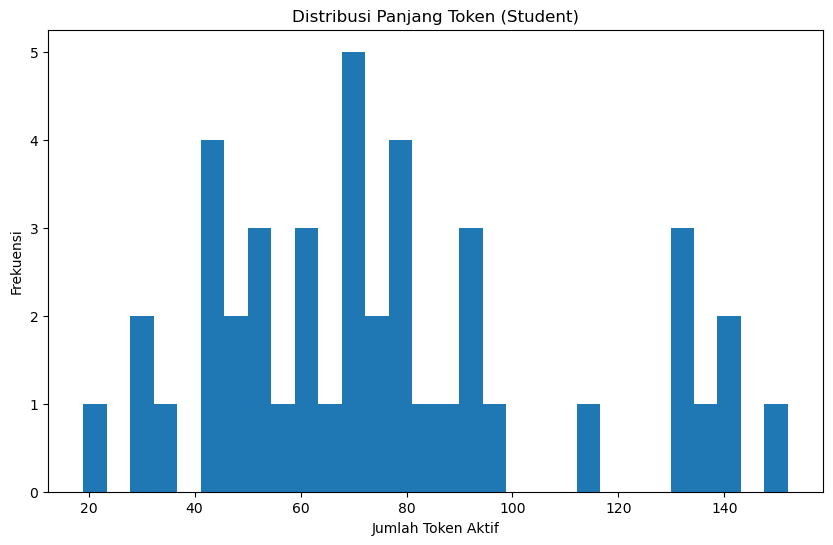

Rata-rata panjang token: 76.58
Persentase terpotong: 0.00%


In [8]:
# Memeriksa distribusi panjang token untuk memastikan max_length cukup
student_lengths = [sum(mask) for mask in std_tokens['attention_mask'].numpy()]
plt.figure(figsize=(10, 6))
plt.hist(student_lengths, bins=30)
plt.title('Distribusi Panjang Token (Student)')
plt.xlabel('Jumlah Token Aktif')
plt.ylabel('Frekuensi')
plt.show()
print(f"Rata-rata panjang token: {np.mean(student_lengths):.2f}")
print(f"Persentase terpotong: {sum(l == 256 for l in student_lengths) / len(student_lengths) * 100:.2f}%")

In [9]:
# Mendekode token untuk memastikan tokenisasi berfungsi dengan baik
sample_text = std_par[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Teks asli: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Teks asli: teknologi adalah segala sesuatu yang menciptakan efisiensi dan efektivitas untuk manusia. pada revolusi industri 4.0 mendorong pertumbuhan teknologi yang sangat pesat dan keberadaan teknologi ini secara tidak langsung akan menciptakan zaman baru yang serba praktis. mengikuti kemajuan ini, sebuah tantangan besar harus dihadapi generasi-generasi muda, salah satunya pelajar. mereka dihadapkan oleh segala kemudahan, apabila tidak disikapi dengan bijak akan menimbulkan banyak spekulasi negatif. hal ini terlihat jelas dari pandangan masyarakat selama ini. masyarakat telah menganggap remeh peran dan aktualisasi proses berkarya dari pelajar di sekitar mereka. menurut sebagian masyarakat, teknologi beserta segala kemudahannya hanya membuat pelajar menjadi pasif dan berleha-leha dengan kesenangan yang dihadirkan dari teknologi.
Token ID: [2, 1429, 154, 1517, 1370, 34, 2800, 7630, 41, 11811, 90, 666, 30470, 126, 7010, 1934, 401, 30470, 502, 3753, 2471, 1429, 34, 310, 7026, 41, 4295, 14

In [10]:
# Jika tokenisasi memakan waktu lama, pertimbangkan untuk menyimpannya
tokenized_data = {
    'student': std_tokens,
    'chatgpt_1 ': gpt_tokens_1 ,
    'chatgpt_2': gpt_tokens_2
}

# Menyimpan input_ids dan attention_mask sebagai numpy arrays
tokenized_numpy = {
    'student': {
        'input_ids': std_tokens['input_ids'].numpy(),
        'attention_mask': std_tokens['attention_mask'].numpy()
    },
    'chatgpt ': {
        'input_ids': gpt_tokens_1 ['input_ids'].numpy(),
        'attention_mask': gpt_tokens_1 ['attention_mask'].numpy()
    },
    'chatgpt_2': {
        'input_ids': gpt_tokens_2['input_ids'].numpy(),
        'attention_mask': gpt_tokens_2['attention_mask'].numpy()
    }
}

with open('tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

In [11]:
# Load model IndoBERT
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False


# Fungsi untuk membuat Bi-Encoder
def build_bi_encoder(bert_model):
    """
    Membuat model Bi-Encoder dengan IndoBERT.
    
    Args:
        bert_model (TFBertModel): Model dasar IndoBERT.
        
    Returns:
        tf.keras.Model: Model Bi-Encoder.
    """
    # Input layer untuk token ID dan attention mask
    input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings dari IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer untuk fine-tuning
    dense1 = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    dropout1 = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(256, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
    dense3 = tf.keras.layers.Dense(256)(dropout2)
    
    # Normalisasi output (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3, axis=1)
    
    # Model Bi-Encoder
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Buat dua Bi-Encoder
bi_encoder_student_chatgpt = build_bi_encoder(bert_model)
bi_encoder_only_chatgpt = build_bi_encoder(bert_model)

# Tampilkan arsitektur
print("Bi-Encoder untuk Student_ChatGPT:")
bi_encoder_student_chatgpt.summary()


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Bi-Encoder untuk Student_ChatGPT:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7     

In [ ]:
def create_contrastive_pairs(student_tokens, chatgpt_tokens_1, chatgpt_tokens_2, max_pairs=None):
    """
    Creates data pairs for contrastive learning with dataset-appropriate quantities.

    Args:
        student_tokens: Tokenized student text
        chatgpt_tokens_1: First set of tokenized ChatGPT text
        chatgpt_tokens_2: Second set of tokenized ChatGPT text
        max_pairs: Maximum number of pairs (optional). If None, uses all possible combinations.

    Returns:
        tuple: Dictionary of anchor, positive, negative pairs and labels, and the total number of pairs.
    """
    # Get dataset sizes
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt_1 = chatgpt_tokens_1['input_ids'].shape[0]
    n_chatgpt_2 = chatgpt_tokens_2['input_ids'].shape[0]
    
    # Calculate maximum possible combinations
    max_student_pairs = (n_student * (n_student - 1)) // 2  # student-student combinations
    max_chatgpt_pairs = (n_chatgpt_1 * (n_chatgpt_1 - 1)) // 2  # chatgpt-chatgpt combinations
    max_negative_pairs = n_student * n_chatgpt_2  # student-chatgpt combinations
    
    # Determine number of pairs to create
    if max_pairs is None:
        # Use minimum number of positive pairs for balance
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Limit negative pairs to balance with positives
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
    else:
        # If max_pairs is specified, use that with equal proportions
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
    
    # Ensure we don't exceed the maximum possible combinations
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)
    
    # Initialize arrays for data pairs
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []
    
    # Generate positive student-student pairs
    if n_pos_student > 0:
        # Create all possible student-student pairs
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Randomly select pairs
        selected_pairs = random.sample(student_pairs, n_pos_student)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (student)
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])
            
            # Positive (another student)
            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])
            
            # Negative (from ChatGPT)
            neg_idx = np.random.choice(n_chatgpt_2)
            negative_input_ids.append(chatgpt_tokens_2['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens_2['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate positive chatgpt-chatgpt pairs
    if n_pos_chatgpt > 0:
        # Create all possible chatgpt-chatgpt pairs
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt_1) for j in range(i+1, n_chatgpt_1)]
        # Randomly select pairs
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (ChatGPT 1)
            anchor_input_ids.append(chatgpt_tokens_1['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens_1['attention_mask'][idx1])
            
            # Positive (ChatGPT 2)
            positive_input_ids.append(chatgpt_tokens_2['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens_2['attention_mask'][idx2])
            
            # Negative (from Student)
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate negative student-chatgpt pairs
    if n_neg_pairs > 0:
        # Create all possible student-chatgpt pairs
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt_2)]
        # Randomly select pairs
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)
        
        for student_idx, chatgpt_idx in selected_pairs:
            # Anchor (Student)
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])
            
            # Negative (ChatGPT)
            negative_input_ids.append(chatgpt_tokens_2['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens_2['attention_mask'][chatgpt_idx])
            
            # Positive (another Student different from anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Ensure there are available indices
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])
                
                # Label (0 for negative pair)
                labels.append(0)
    
    # Count actual pairs created
    actual_pairs = len(labels)
    
    # Convert to tensors and return
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs

In [13]:
# Buat pasangan data untuk model Student_ChatGPT tanpa menentukan n_pairs
student_chatgpt_pairs, total_pairs = create_contrastive_pairs(std_tokens, gpt_tokens_1, gpt_tokens_1)

# Tampilkan jumlah pasangan yang dibuat
print(f"Total contrastive pairs yang dibuat: {total_pairs}")
print(f"- Pasangan positif student-student: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan positif chatgpt-chatgpt: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan negatif student-chatgpt: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 0)}")

# Jika ingin membatasi jumlah maksimum pasangan
# student_chatgpt_pairs, total_pairs = create_contrastive_pairs(student_tokens, chatgpt_tokens_1, max_pairs=1000)

Total contrastive pairs yang dibuat: 1804
- Pasangan positif student-student: 451
- Pasangan positif chatgpt-chatgpt: 451
- Pasangan negatif student-chatgpt: 902


In [14]:
# Buat pasangan data untuk model Only_ChatGPT tanpa menentukan n_pairs
only_chatgpt_pairs, total_pairs = create_contrastive_pairs(std_tokens, gpt_tokens_1, gpt_tokens_2)

# Tampilkan jumlah pasangan yang dibuat
print(f"Total Knowledge GPT pairs yang dibuat: {total_pairs}")
print(f"- Pasangan positif student-student: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan positif chatgpt-chatgpt: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan negatif student-chatgpt: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 0)}")

# Jika ingin membatasi jumlah maksimum pasangan
# only_chatgpt_pairs, total_pairs = create_self_supervised_pairs(chatgpt_tokens_2, max_pairs=1000)

Total Knowledge GPT pairs yang dibuat: 1804
- Pasangan positif student-student: 451
- Pasangan positif chatgpt-chatgpt: 451
- Pasangan negatif student-chatgpt: 902


In [15]:
# Model untuk training dengan triplet loss
def build_triplet_model(bi_encoder):
    """
    Membangun model untuk training dengan triplet loss.
    
    Args:
        bi_encoder: Model bi-encoder yang akan dilatih.
        
    Returns:
        tf.keras.Model: Model untuk training dengan triplet loss.
    """
    # Input untuk anchor, positive, dan negative
    anchor_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="anchor_input_ids")
    anchor_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="anchor_attention_mask")
    
    positive_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="positive_input_ids")
    positive_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="positive_attention_mask")
    
    negative_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="negative_input_ids")
    negative_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="negative_attention_mask")
    
    # Embedding untuk anchor, positive, dan negative
    anchor_embedding = bi_encoder([anchor_input_ids, anchor_attention_mask])
    positive_embedding = bi_encoder([positive_input_ids, positive_attention_mask])
    negative_embedding = bi_encoder([negative_input_ids, negative_attention_mask])
    
    # Hitung cosine similarity
    pos_similarity = tf.reduce_sum(anchor_embedding * positive_embedding, axis=1)
    neg_similarity = tf.reduce_sum(anchor_embedding * negative_embedding, axis=1)
    
    # Output model adalah perbedaan similarity
    output = tf.stack([pos_similarity, neg_similarity], axis=1)
    
    return tf.keras.Model(
        inputs=[
            anchor_input_ids, anchor_attention_mask,
            positive_input_ids, positive_attention_mask,
            negative_input_ids, negative_attention_mask
        ],
        outputs=output
    )

In [16]:
# Custom loss function untuk triplet
def triplet_loss(y_true, y_pred):
    """
    Triplet loss: mendorong similarity positif lebih tinggi dari similarity negatif.
    
    Args:
        y_true: Tidak digunakan dalam triplet loss.
        y_pred: Stack dari [positive_similarity, negative_similarity].
        
    Returns:
        tf.Tensor: Nilai loss.
    """
    pos_sim = y_pred[:, 0]
    neg_sim = y_pred[:, 1]
    margin = 0.5
    
    # Triplet loss: max(0, margin - (pos_sim - neg_sim))
    loss = tf.maximum(0., margin - (pos_sim - neg_sim))
    return tf.reduce_mean(loss)

In [17]:
# Buat model triplet untuk Student_ChatGPT
triplet_model_student_chatgpt = build_triplet_model(bi_encoder_student_chatgpt)

# Compile model
triplet_model_student_chatgpt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Student_ChatGPT
print("Training Bi-Encoder untuk Student_ChatGPT...")
history_student_chatgpt = triplet_model_student_chatgpt.fit(
    x=[
        student_chatgpt_pairs['anchor']['input_ids'],
        student_chatgpt_pairs['anchor']['attention_mask'],
        student_chatgpt_pairs['positive']['input_ids'],
        student_chatgpt_pairs['positive']['attention_mask'],
        student_chatgpt_pairs['negative']['input_ids'],
        student_chatgpt_pairs['negative']['attention_mask']
    ],
    y=student_chatgpt_pairs['labels'],  # Tidak digunakan dalam triplet loss
    epochs=3,
    batch_size=32,
    validation_split=0.3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Training Bi-Encoder untuk Student_ChatGPT...
Epoch 1/3


I0000 00:00:1744543109.481643   61051 service.cc:152] XLA service 0x7f505c2fee40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744543109.481686   61051 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-04-13 18:18:29.486805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744543109.500522   61051 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744543109.602782   61051 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - 144s 3s/step - loss: 0.4893 - val_loss: 0.4942
Epoch 2/3
40/40 [==============================] - 117s 3s/step - loss: 0.4748 - val_loss: 0.4516
Epoch 3/3
40/40 [==============================] - 118s 3s/step - loss: 0.4258 - val_loss: 0.3206


In [18]:
# Buat model triplet untuk Only_ChatGPT
triplet_model_only_chatgpt = build_triplet_model(bi_encoder_only_chatgpt)

# Compile model
triplet_model_only_chatgpt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Only_ChatGPT
print("Training Bi-Encoder untuk Only_ChatGPT...")
history_only_chatgpt = triplet_model_only_chatgpt.fit(
    x=[
        only_chatgpt_pairs['anchor']['input_ids'],
        only_chatgpt_pairs['anchor']['attention_mask'],
        only_chatgpt_pairs['positive']['input_ids'],
        only_chatgpt_pairs['positive']['attention_mask'],
        only_chatgpt_pairs['negative']['input_ids'],
        only_chatgpt_pairs['negative']['attention_mask']
    ],
    y=only_chatgpt_pairs['labels'],  # Tidak digunakan dalam triplet loss
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Training Bi-Encoder untuk Only_ChatGPT...
Epoch 1/3
46/46 [==============================] - 146s 3s/step - loss: 0.4916 - val_loss: 0.4946
Epoch 2/3
46/46 [==============================] - 118s 3s/step - loss: 0.4758 - val_loss: 0.4467
Epoch 3/3
46/46 [==============================] - 119s 3s/step - loss: 0.4218 - val_loss: 0.3121


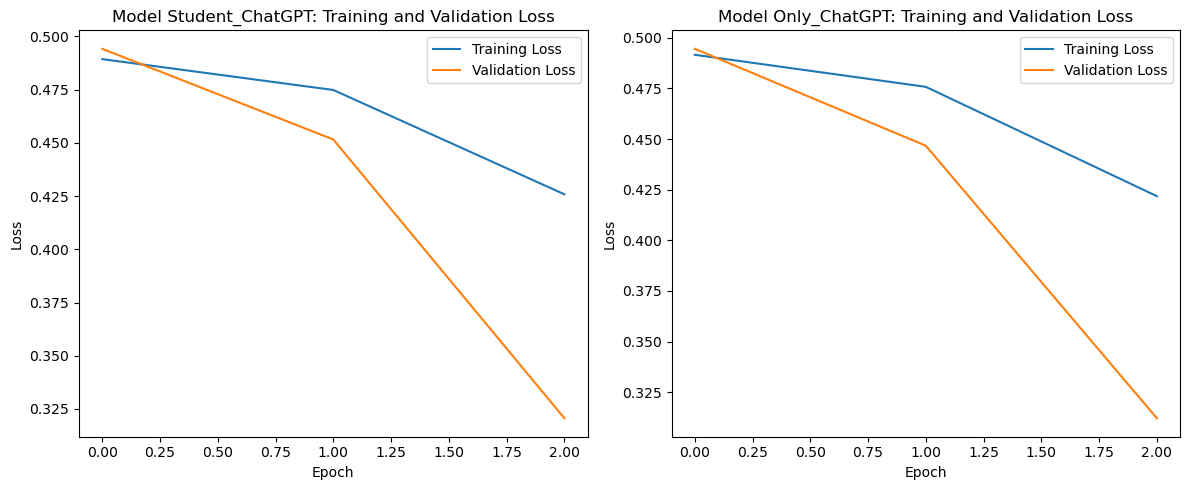

In [19]:
# Plot training history untuk model Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_student_chatgpt.history['loss'], label='Training Loss')
plt.plot(history_student_chatgpt.history['val_loss'], label='Validation Loss')
plt.title('Model Student_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training history untuk model Only_ChatGPT
plt.subplot(1, 2, 2)
plt.plot(history_only_chatgpt.history['loss'], label='Training Loss')
plt.plot(history_only_chatgpt.history['val_loss'], label='Validation Loss')
plt.title('Model Only_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Generate embeddings untuk kalimat Student, ChatGPT_1 dan ChatGPT_2

# Fungsi untuk menghitung similarity score

# Hitung similarity scores X-Student (Model Student_ChatGPT), X-ChatGPT1 (Model Student_ChatGPT), X-ChatGPT2 (Model Only_ChatGPT)

In [21]:
# import tensorflow as tf
# import numpy as np
# import pickle
# import os
# from transformers import BertTokenizer, TFBertModel

# # 1. Muat tokenizer yang sudah disimpan
# tokenizer = BertTokenizer.from_pretrained("saved_models_v2/tokenizer")

# # 2. Definisikan custom_objects untuk memuat model dengan TFBertModel
# custom_objects = {'TFBertModel': TFBertModel}

# # Gunakan custom_object_scope saat memuat model
# with tf.keras.utils.custom_object_scope(custom_objects):
#     # Muat model bi-encoder yang sudah dilatih
#     bi_encoder_student_chatgpt = tf.keras.models.load_model('saved_models_v2/bi_encoder_student_chatgpt.h5')
#     bi_encoder_only_chatgpt = tf.keras.models.load_model('saved_models_v2/bi_encoder_only_chatgpt.h5')

# # 3. Muat data token yang sudah diproses (jika sudah disimpan sebelumnya)
# try:
#     with open('tokenized_data.pkl', 'rb') as f:
#         tokenized_numpy = pickle.load(f)
        
#     # Konversi kembali ke format TensorFlow
#     std_tokens = {
#         'input_ids': tf.convert_to_tensor(tokenized_numpy['student']['input_ids'], dtype=tf.int32),
#         'attention_mask': tf.convert_to_tensor(tokenized_numpy['student']['attention_mask'], dtype=tf.int32)
#     }
    
#     gpt_tokens_1 = {
#         'input_ids': tf.convert_to_tensor(tokenized_numpy['chatgpt ']['input_ids'], dtype=tf.int32),
#         'attention_mask': tf.convert_to_tensor(tokenized_numpy['chatgpt ']['attention_mask'], dtype=tf.int32)
#     }
    
#     gpt_tokens_2 = {
#         'input_ids': tf.convert_to_tensor(tokenized_numpy['chatgpt_2']['input_ids'], dtype=tf.int32),
#         'attention_mask': tf.convert_to_tensor(tokenized_numpy['chatgpt_2']['attention_mask'], dtype=tf.int32)
#     }
    
#     print("Data token berhasil dimuat dari file!")
    
# except (FileNotFoundError, KeyError) as e:
#     print(f"Error saat memuat data token: {e}")
#     print("Perlu memproses data lagi...")

In [22]:
# Fungsi untuk menghasilkan embeddings
def generate_embeddings(tokens, model):
    """
    Menghasilkan embeddings untuk teks.
    
    Args:
        tokens: Token dari teks.
        model: Model bi-encoder.
        
    Returns:
        tf.Tensor: Embeddings.
    """
    return model([tokens['input_ids'], tokens['attention_mask']])

In [23]:
# Fungsi untuk menghitung similarity score dengan agregasi maksimum
def compute_similarity_max(embedding1, embedding2):
    """
    Menghitung similarity score dengan metode agregasi maksimum.
    
    Args:
        embedding1: Embedding pertama (teks input).
        embedding2: Embedding kedua (referensi).
        
    Returns:
        float: Similarity score maksimum.
    """
    # Normalisasi embeddings (L2 norm)
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    # Hitung cosine similarity
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])  # Flatten
    
    # Ambil nilai maksimum
    max_similarity = tf.reduce_max(similarities).numpy()
    return max_similarity

In [24]:
def compute_similarity_avg(embedding1, embedding2):
    """
    Menghitung similarity score dengan metode agregasi rata-rata.
    
    Args:
        embedding1: Embedding pertama (teks input).
        embedding2: Embedding kedua (referensi).
        
    Returns:
        float: Similarity score rata-rata.
    """
    # Normalisasi embeddings (L2 norm)
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    # Hitung cosine similarity
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])  # Flatten
    
    # Ambil nilai rata-rata
    avg_similarity = tf.reduce_mean(similarities).numpy()
    return avg_similarity

In [25]:
if not os.path.exists('saved_models_1_3'):
    os.makedirs('saved_models_1_3')

# Simpan model bi-encoder untuk Student_ChatGPT
bi_encoder_student_chatgpt.save('saved_models_1_3/bi_encoder_student_chatgpt.h5')

# Simpan model bi-encoder untuk Only_ChatGPT
bi_encoder_only_chatgpt.save('saved_models_1_3/bi_encoder_only_chatgpt.h5')

# Save tokenizer configuration
tokenizer.save_pretrained('saved_models_1_3/tokenizer')

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


('saved_models_1_3/tokenizer/tokenizer_config.json',
 'saved_models_1_3/tokenizer/special_tokens_map.json',
 'saved_models_1_3/tokenizer/vocab.txt',
 'saved_models_1_3/tokenizer/added_tokens.json')

In [26]:
custom_objects = {'TFBertModel': TFBertModel}

with tf.keras.utils.custom_object_scope(custom_objects):
    # Muat model bi-encoder yang sudah dilatih
    bi_encoder_student_chatgpt = tf.keras.models.load_model('saved_models_1_3/bi_encoder_student_chatgpt.h5')
    bi_encoder_only_chatgpt = tf.keras.models.load_model('saved_models_1_3/bi_encoder_only_chatgpt.h5')

In [27]:
# Inisialisasi tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained('saved_models_1_3/tokenizer')

# Fungsi untuk tokenisasi teks
def tokenize_text(texts, max_length=256):
    """
    Tokenisasi teks menggunakan tokenizer IndoBERT.
    
    Args:
        texts (list): Daftar teks yang akan di-tokenisasi.
        max_length (int): Panjang maksimum token.
        
    Returns:
        dict: Token hasil tokenisasi, termasuk input_ids dan attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [28]:
# Tokenisasi data
print("Tokenisasi kalimat Student...")
std_tokens = tokenize_text(std_par)

print("Tokenisasi kalimat ChatGPT (Student_ChatGPT)...")
gpt_tokens_1 = tokenize_text(gpt_par_1)

print("Tokenisasi kalimat ChatGPT (Only_ChatGPT)...")
gpt_tokens_2 = tokenize_text(gpt_par_2)

# Tampilkan hasil tokenisasi (contoh: Student)
print("\nContoh hasil tokenisasi:")
print(std_tokens['input_ids'][:1])  # Input token ID
print(std_tokens['attention_mask'][:1])  # Attention mask

Tokenisasi kalimat Student...
Tokenisasi kalimat ChatGPT (Student_ChatGPT)...
Tokenisasi kalimat ChatGPT (Only_ChatGPT)...

Contoh hasil tokenisasi:
tf.Tensor(
[[    2  1429   154  1517  1370    34  2800  7630    41 11811    90   666
  30470   126  7010  1934   401 30470   502  3753  2471  1429    34   310
   7026    41  4295  1429    92   339   119   728   150  2800  3043   440
     34  7734  4598 30470  1893  4574    92 30468   492  4776   421   308
   6909  3500 30469  3500  1734 30468   427  3040  5308 30470   267 13300
    213  1517  5997 30468  1496   119  3135 10941 30356    79  7051   150
   2798   271 18635  3778 30470   269    92  1457  1127    98  3390   552
    776    92 30470   552   351  4480 20781  2693    41 28510   699 11146
     98  5308    26   947   267 30470   807  1336   552 30468  1429  3983
   1517  5997    57   344   386  5308   234 10603    41   672 28440 30469
   5245 30354    79 10606    34 17910    98  1429 30470     3     0     0
      0     0     0     0 

In [29]:
# Mendekode token untuk memastikan tokenisasi berfungsi dengan baik
sample_text = std_par[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Teks asli: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Teks asli: teknologi adalah segala sesuatu yang menciptakan efisiensi dan efektivitas untuk manusia. pada revolusi industri 4.0 mendorong pertumbuhan teknologi yang sangat pesat dan keberadaan teknologi ini secara tidak langsung akan menciptakan zaman baru yang serba praktis. mengikuti kemajuan ini, sebuah tantangan besar harus dihadapi generasi-generasi muda, salah satunya pelajar. mereka dihadapkan oleh segala kemudahan, apabila tidak disikapi dengan bijak akan menimbulkan banyak spekulasi negatif. hal ini terlihat jelas dari pandangan masyarakat selama ini. masyarakat telah menganggap remeh peran dan aktualisasi proses berkarya dari pelajar di sekitar mereka. menurut sebagian masyarakat, teknologi beserta segala kemudahannya hanya membuat pelajar menjadi pasif dan berleha-leha dengan kesenangan yang dihadirkan dari teknologi.
Token ID: [2, 1429, 154, 1517, 1370, 34, 2800, 7630, 41, 11811, 90, 666, 30470, 126, 7010, 1934, 401, 30470, 502, 3753, 2471, 1429, 34, 310, 7026, 41, 4295, 14

In [ ]:
# Generate embeddings untuk semua data
print("Generating embeddings for Student (Student_ChatGPT)...")
student_emb1 = generate_embeddings(std_tokens, bi_encoder_student_chatgpt)
print("Generating embeddings for ChatGPT-1 (Student_ChatGPT)...")
chatgpt1_emb1 = generate_embeddings(gpt_tokens_1, bi_encoder_student_chatgpt)

#2
print("Generating embeddings for Student (Only_ChatGPT)...")
student_emb2 = generate_embeddings(std_tokens, bi_encoder_only_chatgpt)
print("Generating embeddings for ChatGPT-1 (Only_ChatGPT)...")
chatgpt1_emb2 = generate_embeddings(gpt_tokens_1, bi_encoder_only_chatgpt)
print("Generating embeddings for ChatGPT-2 (Only_ChatGPT)...")
chatgpt2_emb2 = generate_embeddings(gpt_tokens_2, bi_encoder_only_chatgpt)



In [ ]:
# 1. Similarity dengan Student (dari model Student_ChatGPT)
student_student_sim_scores = []
student_gpt1_sim_scores = []
for emb in student_emb1:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), student_emb1)
    student_student_sim_scores.append(avg_similarity)

    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt1_emb1)
    student_gpt1_sim_scores.append(avg_similarity)


# 2. Similarity dengan ChatGPT (dari model Student_ChatGPT)
gpt1_student_sim_scores = []
gpt1_gpt1_sim_scores = []
for emb in chatgpt1_emb1:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), student_emb1)
    gpt1_student_sim_scores.append(avg_similarity)

    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt1_emb1)
    gpt1_gpt1_sim_scores.append(avg_similarity)

# 3. Similarity dengan ChatGPT Knowledge (dari model Only_ChatGPT)
gpt2_student_sim_scores = []
gpt2_gpt1_sim_scores = []
desired_count = len(student_emb1)
np.random.seed(42)
random_indices = np.random.choice(len(chatgpt2_emb2), size=desired_count, replace=False)
for idx in random_indices:
    emb = chatgpt2_emb2[idx]
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), student_emb2)
    gpt2_student_sim_scores.append(avg_similarity)

    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt1_emb2)
    gpt2_gpt1_sim_scores.append(avg_similarity)

min_length = min(len(student_student_sim_scores), len(student_gpt1_sim_scores))
student_similarity_scores = np.array([
    student_student_sim_scores[:min_length], 
    student_gpt1_sim_scores[:min_length]
])

min_length = min(len(gpt1_student_sim_scores), len(gpt1_gpt1_sim_scores))
chatgpt1_similarity_scores = np.array([
    gpt1_student_sim_scores[:min_length], 
    gpt1_gpt1_sim_scores[:min_length]
])

min_length = min(len(gpt2_student_sim_scores), len(gpt2_gpt1_sim_scores))
chatgpt2_similarity_scores = np.array([
    gpt2_student_sim_scores[:min_length], 
    gpt2_gpt1_sim_scores[:min_length]
])

print(student_similarity_scores.shape)
print(chatgpt1_similarity_scores.shape)
print(chatgpt2_similarity_scores.shape)

# Simpan similarity scores untuk digunakan dalam klasifikasi
reference_embeddings_1 = {
    'student': {
        'embeddings': student_emb1.numpy(),
        'similarity_scores': student_similarity_scores
    },
    'chatgpt': {
        'embeddings': chatgpt1_emb1.numpy(),
        'similarity_scores': chatgpt1_similarity_scores
    }
}

reference_embeddings_2 = {
    'chatgpt_knowledge': {
        'embeddings': chatgpt2_emb2.numpy(),
        'similarity_scores': chatgpt2_similarity_scores
    }
}

Generating embeddings for Student (Student_ChatGPT)...
Generating embeddings for ChatGPT-1 (Student_ChatGPT)...
Generating embeddings for Student (Only_ChatGPT)...
Generating embeddings for ChatGPT-1 (Only_ChatGPT)...
Generating embeddings for ChatGPT-2 (Only_ChatGPT)...
(2, 43)
(2, 43)
(2, 43)


In [31]:
# Simpan model Bi-Encoder untuk student_chatgpt

# Simpan model Bi-Encoder untuk only_chatgpt

# Simpan tokenizer configuration

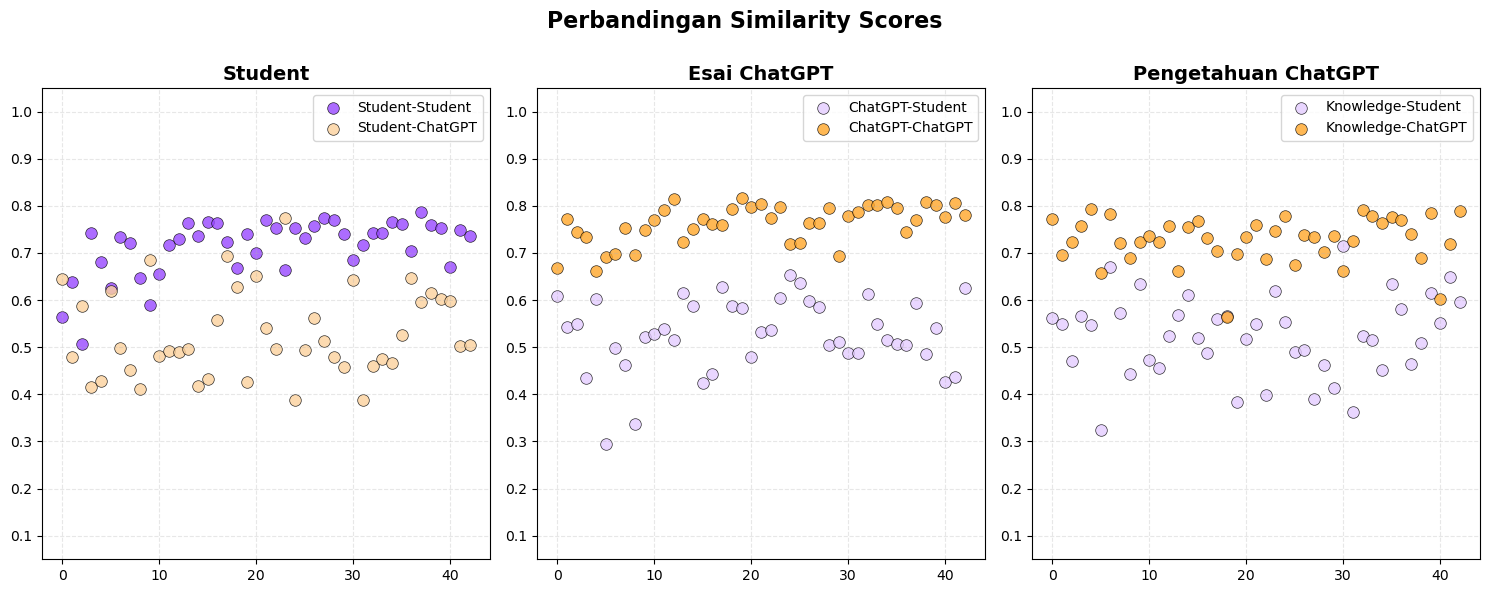

In [ ]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(student_student_sim_scores)), student_student_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(student_gpt1_sim_scores)), student_gpt1_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: Esai ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt1_student_sim_scores)), gpt1_student_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt1_gpt1_sim_scores)), gpt1_gpt1_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Esai ChatGPT', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 3: Pengetahuan ChatGPT
plt.subplot(1, 3, 3)
plt.scatter(range(len(gpt2_student_sim_scores)), gpt2_student_sim_scores, 
            label='Knowledge-Student', color="#E4CCFF", s=70, alpha=0.8, edgecolor='black', linewidth=0.5) 
plt.scatter(range(len(gpt2_gpt1_sim_scores)), gpt2_gpt1_sim_scores, 
            label='Knowledge-ChatGPT', color="#FFA629", s=70, alpha=0.8, edgecolor='black', linewidth=0.5)  
plt.title('Pengetahuan ChatGPT', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Perbandingan Similarity Scores', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  


plt.savefig('similarity_comparison_presentation.png', dpi=300, bbox_inches='tight')

plt.show()

In [33]:
with open('saved_models_1_3/reference_embeddings_1.pkl', 'wb') as f:
    pickle.dump(reference_embeddings_1, f)

with open('saved_models_1_3/reference_embeddings_2.pkl', 'wb') as f:
    pickle.dump(reference_embeddings_2, f)

print("Reference embeddings saved successfully!")

Reference embeddings saved successfully!


In [34]:
def extract_stylometric_features(text):
    """
    Ekstraksi fitur stylometric dari teks:
    - Variasi panjang kata
    - Variasi panjang kalimat
    - Rasio Stopwords
    - Jumlah koma
    - Jumlah titik
    
    Args:
        text (str): Input teks.
        
    Returns:
        dict: Fitur stylometric.
    """
    # Tokenisasi kata dan kalimat
    words = re.findall(r'\b\w+\b', text)  # Token kata
    sentences = re.split(r'[.!?]', text)  # Token kalimat
    
    # Basic features
    n_words = len(words)

    # Syntactic features
    punctuation_count = len(re.findall(r'[.,!?;:]', text))
    
    # Variasi panjang kata
    word_length_std = np.std([len(word) for word in words]) if n_words > 0 else 0
    
    # Variasi panjang kalimat
    sentence_lengths = [len(s.split()) for s in sentences if s.strip()]
    sentence_length_std = np.std(sentence_lengths) if len(sentence_lengths) > 0 else 0
    
    # Rasio Stopwords
    stopwords = {'a','ada','adalah','adanya','adapun','agak','agaknya','agar','akan','akankah','akhir',
            'akhiri','akhirnya','aku','akulah','amat','amatlah','anda','andalah','antar','antara',
            'antaranya','apa','apaan','apabila','apakah','apalagi','apatah','arti','artinya','asal',
            'asalkan','atas','atau','ataukah','ataupun','awal','awalnya','b','bagai','bagaikan',
            'bagaimana','bagaimanakah','bagaimanapun','bagainamakah','bagi','bagian','bahkan','bahwa',
            'bahwasannya','bahwasanya','baik','baiklah','bakal','bakalan','balik','banyak','bapak',
            'baru','bawah','beberapa','begini','beginian','beginikah','beginilah','begitu','begitukah',
            'begitulah','begitupun','bekerja','belakang','belakangan','belum','belumlah','benar',
            'benarkah','benarlah','berada','berakhir','berakhirlah','berakhirnya','berapa','berapakah',
            'berapalah','berapapun','berarti','berawal','berbagai','berdatangan','beri','berikan',
            'berikut','berikutnya','berjumlah','berkali-kali','berkata','berkehendak','berkeinginan',
            'berkenaan','berlainan','berlalu','berlangsung','berlebihan','bermacam','bermacam-macam',
            'bermaksud','bermula','bersama','bersama-sama','bersiap','bersiap-siap','bertanya',
            'bertanya-tanya','berturut','berturut-turut','bertutur','berujar','berupa','besar',
            'betul','betulkah','biasa','biasanya','bila','bilakah','bisa','bisakah','boleh','bolehkah',
            'bolehlah','buat','bukan','bukankah','bukanlah','bukannya','bulan','bung','c','cara',
            'caranya','cukup','cukupkah','cukuplah','cuma','d','dahulu','dalam','dan','dapat','dari',
            'daripada','datang','dekat','demi','demikian','demikianlah','dengan','depan','di','dia',
            'diakhiri','diakhirinya','dialah','diantara','diantaranya','diberi','diberikan','diberikannya',
            'dibuat','dibuatnya','didapat','didatangkan','digunakan','diibaratkan','diibaratkannya',
            'diingat','diingatkan','diinginkan','dijawab','dijelaskan','dijelaskannya','dikarenakan',
            'dikatakan','dikatakannya','dikerjakan','diketahui','diketahuinya','dikira','dilakukan',
            'dilalui','dilihat','dimaksud','dimaksudkan','dimaksudkannya','dimaksudnya','diminta',
            'dimintai','dimisalkan','dimulai','dimulailah','dimulainya','dimungkinkan','dini','dipastikan',
            'diperbuat','diperbuatnya','dipergunakan','diperkirakan','diperlihatkan','diperlukan',
            'diperlukannya','dipersoalkan','dipertanyakan','dipunyai','diri','dirinya','disampaikan',
            'disebut','disebutkan','disebutkannya','disini','disinilah','ditambahkan','ditandaskan',
            'ditanya','ditanyai','ditanyakan','ditegaskan','ditujukan','ditunjuk','ditunjuki','ditunjukkan',
            'ditunjukkannya','ditunjuknya','dituturkan','dituturkannya','diucapkan','diucapkannya',
            'diungkapkan','dong','dua','dulu','e','empat','enak','enggak','enggaknya','entah','entahlah',
            'f','g','guna','gunakan','h','hadap','hai','hal','halo','hallo','hampir','hanya','hanyalah',
            'hari','harus','haruslah','harusnya','helo','hello','hendak','hendaklah','hendaknya','hingga',
            'i','ia','ialah','ibarat','ibaratkan','ibaratnya','ibu','ikut','ingat','ingat-ingat','ingin',
            'inginkah','inginkan','ini','inikah','inilah','itu','itukah','itulah','j','jadi','jadilah',
            'jadinya','jangan','jangankan','janganlah','jauh','jawab','jawaban','jawabnya','jelas',
            'jelaskan','jelaslah','jelasnya','jika','jikalau','juga','jumlah','jumlahnya','justru',
            'k','kadar','kala','kalau','kalaulah','kalaupun','kali','kalian','kami','kamilah','kamu',
            'kamulah','kan','kapan','kapankah','kapanpun','karena','karenanya','kasus','kata','katakan',
            'katakanlah','katanya','ke','keadaan','kebetulan','kecil','kedua','keduanya','keinginan',
            'kelamaan','kelihatan','kelihatannya','kelima','keluar','kembali','kemudian','kemungkinan',
            'kemungkinannya','kena','kenapa','kepada','kepadanya','kerja','kesampaian','keseluruhan',
            'keseluruhannya','keterlaluan','ketika','khusus','khususnya','kini','kinilah','kira',
            'kira-kira','kiranya','kita','kitalah','kok','kurang','l','lagi','lagian','lah','lain',
            'lainnya','laku','lalu','lama','lamanya','langsung','lanjut','lanjutnya','lebih','lewat',
            'lihat','lima','luar','m','macam','maka','makanya','makin','maksud','malah','malahan',
            'mampu','mampukah','mana','manakala','manalagi','masa','masalah','masalahnya','masih',
            'masihkah','masing','masing-masing','masuk','mata','mau','maupun','melainkan','melakukan',
            'melalui','melihat','melihatnya','memang','memastikan','memberi','memberikan','membuat',
            'memerlukan','memihak','meminta','memintakan','memisalkan','memperbuat','mempergunakan',
            'memperkirakan','memperlihatkan','mempersiapkan','mempersoalkan','mempertanyakan','mempunyai',
            'memulai','memungkinkan','menaiki','menambahkan','menandaskan','menanti','menanti-nanti',
            'menantikan','menanya','menanyai','menanyakan','mendapat','mendapatkan','mendatang','mendatangi',
            'mendatangkan','menegaskan','mengakhiri','mengapa','mengatakan','mengatakannya','mengenai',
            'mengerjakan','mengetahui','menggunakan','menghendaki','mengibaratkan','mengibaratkannya',
            'mengingat','mengingatkan','menginginkan','mengira','mengucapkan','mengucapkannya','mengungkapkan',
            'menjadi','menjawab','menjelaskan','menuju','menunjuk','menunjuki','menunjukkan','menunjuknya',
            'menurut','menuturkan','menyampaikan','menyangkut','menyatakan','menyebutkan','menyeluruh',
            'menyiapkan','merasa','mereka','merekalah','merupakan','meski','meskipun','meyakini','meyakinkan',
            'minta','mirip','misal','misalkan','misalnya','mohon','mula','mulai','mulailah','mulanya','mungkin',
            'mungkinkah','n','nah','naik','namun','nanti','nantinya','nya','nyaris','nyata','nyatanya',
            'o','oleh','olehnya','orang','p','pada','padahal','padanya','pak','paling','panjang','pantas',
            'para','pasti','pastilah','penting','pentingnya','per','percuma','perlu','perlukah','perlunya',
            'pernah','persoalan','pertama','pertama-tama','pertanyaan','pertanyakan','pihak','pihaknya',
            'pukul','pula','pun','punya','q','r','rasa','rasanya','rupa','rupanya','s','saat','saatnya','saja',
            'sajalah','salam','saling','sama','sama-sama','sambil','sampai','sampai-sampai','sampaikan','sana',
            'sangat','sangatlah','sangkut','satu','saya','sayalah','se','sebab','sebabnya','sebagai',
            'sebagaimana','sebagainya','sebagian','sebaik','sebaik-baiknya','sebaiknya','sebaliknya',
            'sebanyak','sebegini','sebegitu','sebelum','sebelumnya','sebenarnya','seberapa','sebesar',
            'sebetulnya','sebisanya','sebuah','sebut','sebutlah','sebutnya','secara','secukupnya','sedang',
            'sedangkan','sedemikian','sedikit','sedikitnya','seenaknya','segala','segalanya','segera',
            'seharusnya','sehingga','seingat','sejak','sejauh','sejenak','sejumlah','sekadar','sekadarnya',
            'sekali','sekali-kali','sekalian','sekaligus','sekalipun','sekarang','sekaranglah','sekecil',
            'seketika','sekiranya','sekitar','sekitarnya','sekurang-kurangnya','sekurangnya','sela','selain',
            'selaku','selalu','selama','selama-lamanya','selamanya','selanjutnya','seluruh','seluruhnya',
            'semacam','semakin','semampu','semampunya','semasa','semasih','semata','semata-mata','semaunya',
            'sementara','semisal','semisalnya','sempat','semua','semuanya','semula','sendiri','sendirian',
            'sendirinya','seolah','seolah-olah','seorang','sepanjang','sepantasnya','sepantasnyalah',
            'seperlunya','seperti','sepertinya','sepihak','sering','seringnya','serta','serupa','sesaat',
            'sesama','sesampai','sesegera','sesekali','seseorang','sesuatu','sesuatunya','sesudah',
            'sesudahnya','setelah','setempat','setengah','seterusnya','setiap','setiba','setibanya',
            'setidak-tidaknya','setidaknya','setinggi','seusai','sewaktu','siap','siapa','siapakah',
            'siapapun','sini','sinilah','soal','soalnya','suatu','sudah','sudahkah','sudahlah','supaya',
            't','tadi','tadinya','tahu','tak','tambah','tambahnya','tampak','tampaknya','tandas','tandasnya',
            'tanpa','tanya','tanyakan','tanyanya','tapi','tegas','tegasnya','telah','tempat','tentang','tentu',
            'tentulah','tentunya','tepat','terakhir','terasa','terbanyak','terdahulu','terdapat','terdiri',
            'terhadap','terhadapnya','teringat','teringat-ingat','terjadi','terjadilah','terjadinya','terkira',
            'terlalu','terlebih','terlihat','termasuk','ternyata','tersampaikan','tersebut','tersebutlah',
            'tertentu','tertuju','terus','terutama','tetap','tetapi','tiap','tiba','tiba-tiba','tidak',
            'tidakkah','tidaklah','tiga','toh','tuju','tunjuk','turut','tutur','tuturnya','u','ucap','ucapnya',
            'ujar','ujarnya','umumnya','ungkap','ungkapnya','untuk','usah','usai','v','w','waduh','wah','wahai',
            'waktunya','walau','walaupun','wong','x','y','ya','yaitu','yakin','yakni','yang','z'}
    stopwords_count = sum(1 for word in words if word.lower() in stopwords)
    stopwords_ratio = stopwords_count / n_words if n_words > 0 else 0
    
    # Distribusi tanda baca
    punctuation_distribution = Counter(re.findall(r'[.,!?;:]', text))
    comma_count = punctuation_distribution.get(',', 0)
    period_count = punctuation_distribution.get('.', 0)
    
    return {
        'word_length_std': word_length_std,
        'sentence_length_std': sentence_length_std,
        'stopwords_ratio': stopwords_ratio,
        'comma_count': comma_count,
        'period_count': period_count,
    }

# Ekstraksi fitur untuk semua dataset
print("Ekstraksi fitur stylometric untuk Student...")
student_features = [extract_stylometric_features(text) for text in std_par]

print("Ekstraksi fitur stylometric untuk ChatGPT (Student_ChatGPT)...")
chatgpt_features_1 = [extract_stylometric_features(text) for text in gpt_par_1]

print("Ekstraksi fitur stylometric untuk ChatGPT (Only_ChatGPT)...")
chatgpt_features_2 = [extract_stylometric_features(text) for text in gpt_par_2]

# Konversi fitur ke DataFrame
student_features_df = pd.DataFrame(student_features)
chatgpt_features_1_df = pd.DataFrame(chatgpt_features_1)
chatgpt_features_2_df = pd.DataFrame(chatgpt_features_2)

# Tampilkan beberapa fitur hasil ekstraksi
print("\nFitur Stylometric Student:")
display(student_features_df.head())

print("\nFitur Stylometric ChatGPT (Student_ChatGPT):")
display(chatgpt_features_1_df.head())

print("\nFitur Stylometric ChatGPT (Only_ChatGPT):")
display(chatgpt_features_2_df.head())

Ekstraksi fitur stylometric untuk Student...
Ekstraksi fitur stylometric untuk ChatGPT (Student_ChatGPT)...
Ekstraksi fitur stylometric untuk ChatGPT (Only_ChatGPT)...

Fitur Stylometric Student:


,word_length_std,sentence_length_std,stopwords_ratio,comma_count,period_count
0,2.481545,5.218656,0.477064,4,8
1,2.098691,7.342913,0.551724,6,5
2,2.138085,11.021444,0.545455,8,6
3,2.652303,2.692582,0.545455,1,3
4,2.105023,7.642523,0.346154,4,6



Fitur Stylometric ChatGPT (Student_ChatGPT):


,word_length_std,sentence_length_std,stopwords_ratio,comma_count,period_count
0,2.230836,3.136877,0.493976,12,5
1,2.168220,3.440930,0.458824,11,5
2,2.597928,3.200000,0.513889,4,5
3,2.503538,6.046487,0.515789,5,5
4,2.803085,3.867816,0.477778,6,5



Fitur Stylometric ChatGPT (Only_ChatGPT):


,word_length_std,sentence_length_std,stopwords_ratio,comma_count,period_count
0,2.548949,5.590170,0.442857,9,4
1,2.380188,3.766630,0.444444,6,4
2,2.647580,2.561250,0.432432,4,5
3,2.506990,2.947457,0.475000,4,4
4,2.462171,3.832427,0.485294,4,4


In [35]:
# Gabungkan semua fitur untuk normalisasi
all_features = pd.concat([student_features_df, chatgpt_features_1_df, chatgpt_features_2_df], axis=0)

# Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Pisahkan kembali fitur yang telah dinormalisasi
n_student = len(student_features_df)
n_chatgpt_1 = len(chatgpt_features_1_df)

student_features_normalized = normalized_features[:n_student]
chatgpt_features_1_normalized = normalized_features[n_student:n_student + n_chatgpt_1]
chatgpt_features_2_normalized = normalized_features[n_student + n_chatgpt_1:]

print("Fitur Student setelah normalisasi:")
print(student_features_normalized[:5])

# Simpan scaler untuk inference nanti
with open('scaler_stylometric.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Fitur Student setelah normalisasi:
[[ 0.07629427  0.43243714  0.12815497 -0.1252596   4.12793015]
 [-1.46935012  1.44802453  1.30799094  0.77133543  1.2107324 ]
 [-1.31030844  3.20669636  1.20891381  1.66793046  2.18313165]
 [ 0.76566957 -0.77525561  1.20891381 -1.47015215 -0.7340661 ]
 [-1.44378771  1.59126561 -1.94059588 -0.1252596   2.18313165]]


In [36]:
# Tambahkan label pada dataset untuk visualisasi
student_features_df['label'] = 'Esai Siswa'
chatgpt_features_1_df['label'] = 'Esai ChatGPT'
chatgpt_features_2_df['label'] = 'Pengetahuan ChatGPT'

# Gabungkan dataset
combined_features = pd.concat([student_features_df, chatgpt_features_1_df, chatgpt_features_2_df], axis=0)

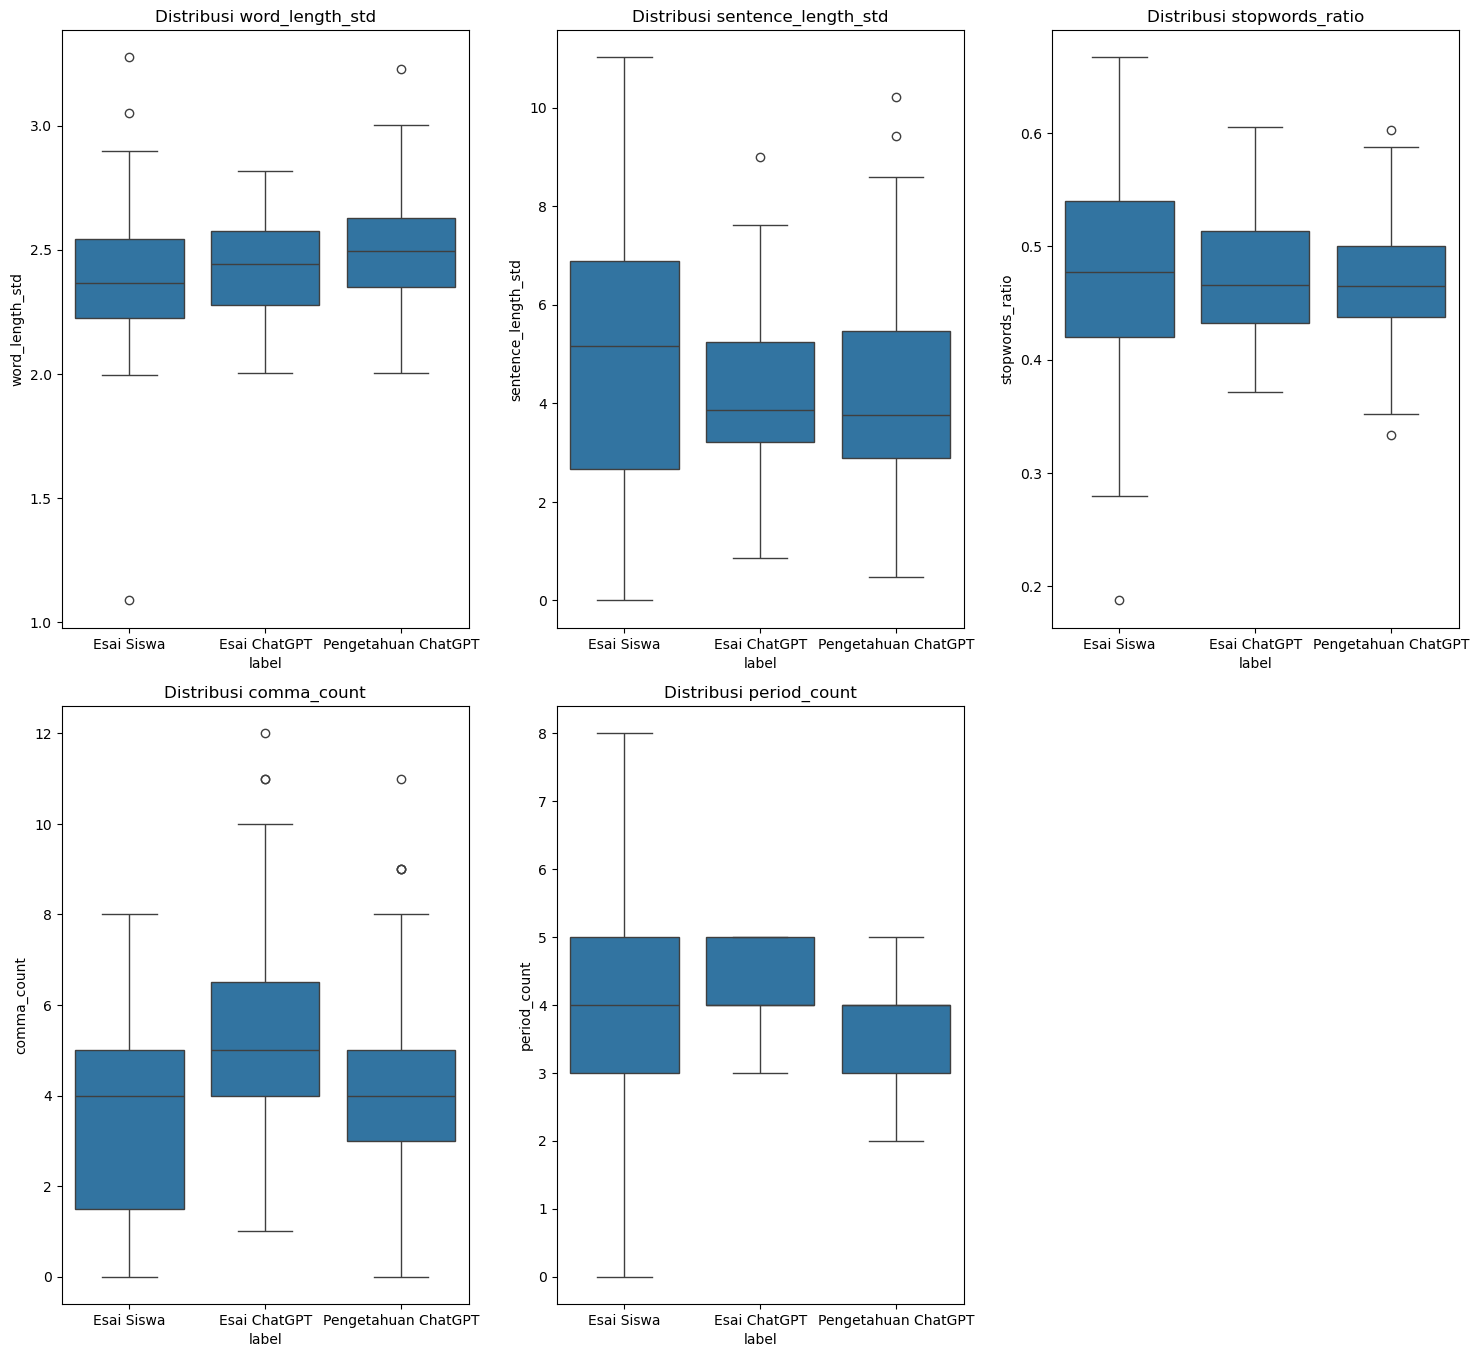

In [37]:
plt.figure(figsize=(15, 20))
for i, feature in enumerate([
    'word_length_std', 
    'sentence_length_std', 
    'stopwords_ratio', 
    'comma_count', 
    'period_count'
]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='label', y=feature, data=combined_features)
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()

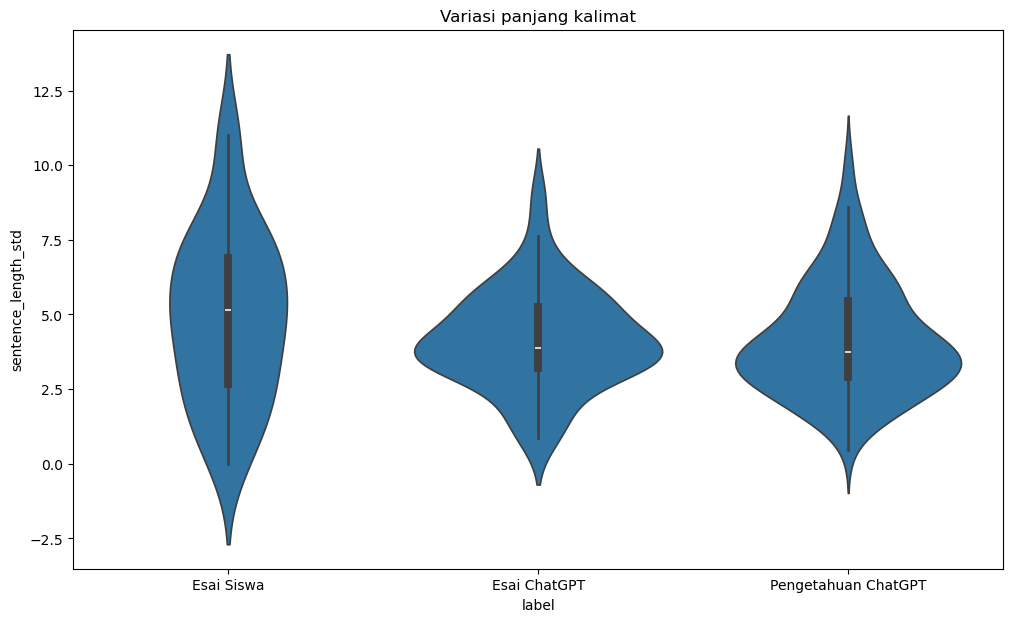

In [38]:
plt.figure(figsize=(12, 7))
sns.violinplot(x='label', y='sentence_length_std', data=combined_features, inner='box')
plt.title('Variasi panjang kalimat')
plt.show()

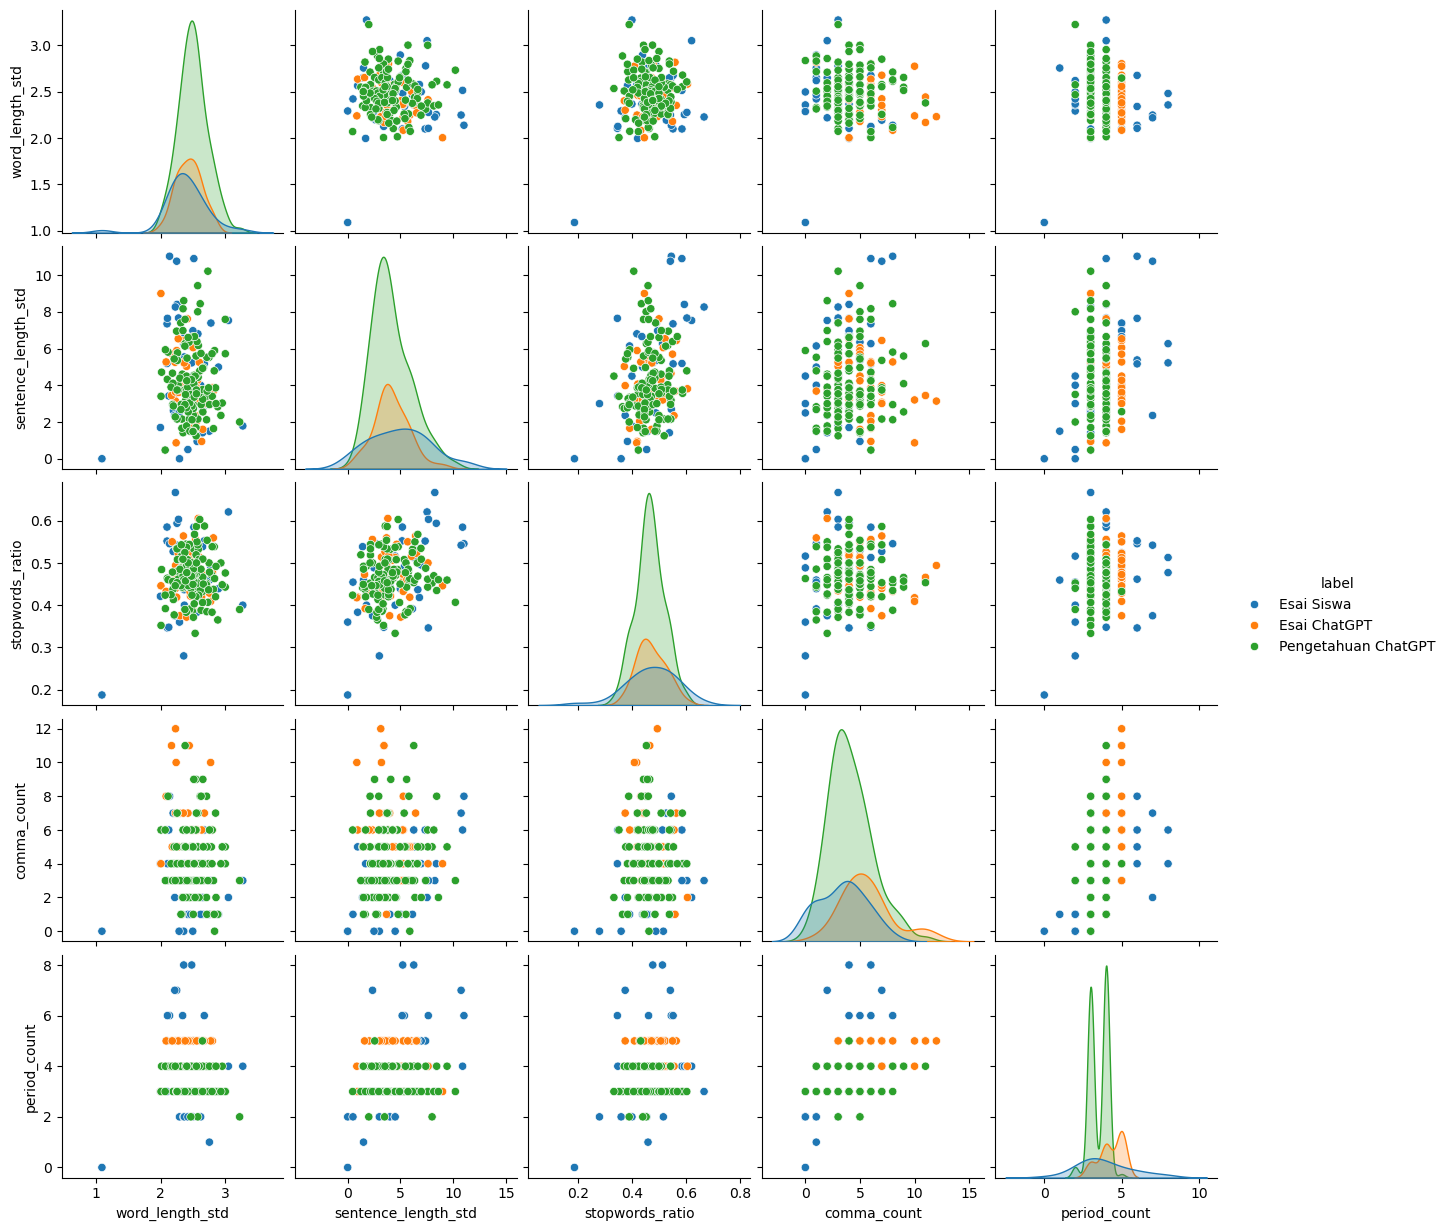

In [39]:
sns.pairplot(combined_features, hue='label', vars=[
    'word_length_std', 
    'sentence_length_std', 
    'stopwords_ratio', 
    'comma_count', 
    'period_count'])
plt.show()



In [ ]:
print(f"student_similarity_scores shape: {student_similarity_scores.shape}")
print(f"chatgpt1_similarity_scores shape: {chatgpt1_similarity_scores.shape}")
print(f"chatgpt2_similarity_scores shape: {chatgpt2_similarity_scores.shape}")

student_similarity_scores shape: (2, 43)
chatgpt1_similarity_scores shape: (2, 43)
chatgpt2_similarity_scores shape: (2, 43)
student_embeddings_1 shape: (43, 256)
chatgpt_embeddings_1 shape: (43, 256)
chatgpt_embeddings_2 shape: (118, 256)


In [ ]:
# Combine embeddings for model 1 (already correct)
embeddings_model_1 = np.vstack([student_emb1.numpy(), chatgpt1_emb1.numpy()])
embeddings_model_2 = np.vstack([student_emb2.numpy(), chatgpt1_emb2.numpy()])

student_features_selected = student_features_normalized
chatgpt_features_selected = chatgpt_features_1_normalized

all_stylometric_features = np.vstack([
    student_features_selected,
    chatgpt_features_selected
])

student_gpt2_sim_scores = []
for emb in student_emb2:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt2_emb2)
    student_gpt2_sim_scores.append(avg_similarity)

gpt1_gpt2_sim_scores = []
for emb in chatgpt1_emb2:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt2_emb2)
    gpt1_gpt2_sim_scores.append(avg_similarity)

# Gabungkan similarity scores untuk student dan chatgpt
min_length = min(len(student_student_sim_scores), len(student_gpt1_sim_scores), len(gpt2_student_sim_scores))
student_similarity_combined = np.column_stack([
    student_student_sim_scores[:min_length], 
    student_gpt1_sim_scores[:min_length], 
    student_gpt2_sim_scores[:min_length]
])

min_length = min(len(gpt1_student_sim_scores), len(gpt1_gpt1_sim_scores), len(gpt2_gpt1_sim_scores))
chatgpt1_similarity_combined = np.column_stack([
    gpt1_student_sim_scores[:min_length], 
    gpt1_gpt1_sim_scores[:min_length], 
    gpt1_gpt2_sim_scores[:min_length]
])

all_similarity_scores = np.vstack([
    student_similarity_combined,
    chatgpt1_similarity_combined,
])

# Create labels
student_labels = np.zeros(len(student_embeddings_1))  # Label 0 for Student
chatgpt_labels = np.ones(len(chatgpt_embeddings_1))   # Label 1 for ChatGPT
all_labels = np.hstack([student_labels, chatgpt_labels])

# Verify shapes
print(f"embeddings_model_1 shape: {embeddings_model_1.shape}")
print(f"embeddings_model_2 shape: {embeddings_model_2.shape}")
print(f"all_stylometric_features shape: {all_stylometric_features.shape}")
print(f"all_similarity_scores shape: {all_similarity_scores.shape}")
print(f"all_labels shape: {all_labels.shape}")

embeddings_model_1 shape: (86, 256)
embeddings_model_2 shape: (86, 256)
all_stylometric_features shape: (86, 5)
all_similarity_scores shape: (86, 3)
all_labels shape: (86,)


In [51]:
# Input layers untuk tiga jenis fitur
bert_embedding_input_1 = tf.keras.layers.Input(
    shape=(256,),  # Shape embeddings (diambil dari output model bi-encoder Student_ChatGPT)
    dtype=tf.float32, 
    name="bert_embedding_1"
)
bert_embedding_input_2 = tf.keras.layers.Input(
    shape=(256,),  # Shape embeddings (diambil dari output model bi-encoder Only_ChatGPT)
    dtype=tf.float32, 
    name="bert_embedding_2"
)
stylometric_input = tf.keras.layers.Input(
    shape=(5,),  # Shape jumlah fitur stylometric
    dtype=tf.float32, 
    name="stylometric_features"
)
similarity_score_input = tf.keras.layers.Input(
    shape=(3,),  # Shape score similarity (Student, ChatGPT1, ChatGPT2)
    dtype=tf.float32, 
    name="similarity_score"
)

# Dense layer untuk masing-masing input
bert_dense_1 = tf.keras.layers.Dense(128, activation="relu")(bert_embedding_input_1)
bert_dense_2 = tf.keras.layers.Dense(128, activation="relu")(bert_embedding_input_2)
style_dense = tf.keras.layers.Dense(64, activation="relu")(stylometric_input)
sim_dense = tf.keras.layers.Dense(16, activation="relu")(similarity_score_input)

# Gabungkan semua fitur
combined = tf.keras.layers.Concatenate()([bert_dense_1, bert_dense_2, style_dense, sim_dense])

# Dense layers untuk klasifikasi
x = tf.keras.layers.Dense(128, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Buat model classifier
classifier = tf.keras.Model(
    inputs=[bert_embedding_input_1, bert_embedding_input_2, stylometric_input, similarity_score_input],
    outputs=output,
    name="text_classifier"
)

# Compile model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Tampilkan arsitektur model
classifier.summary()

Model: "text_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_embedding_1 (InputLay  [(None, 256)]                0         []                            
 er)                                                                                              
                                                                                                  
 bert_embedding_2 (InputLay  [(None, 256)]                0         []                            
 er)                                                                                              
                                                                                                  
 stylometric_features (Inpu  [(None, 5)]                  0         []                            
 tLayer)                                                                            

In [52]:
# Split data into training, validation, and test sets
train_idx, temp_idx = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.3,
    random_state=42,
    stratify=all_labels
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.33,  # 10% dari total (0.33 * 0.3 = 0.1)
    random_state=42,
    stratify=all_labels[temp_idx]
)

# Prepare inputs for training, validation, and test
train_inputs = {
    "bert_embedding_1": embeddings_model_1[train_idx],
    "bert_embedding_2": embeddings_model_2[train_idx],
    "stylometric_features": all_stylometric_features[train_idx],
    "similarity_score": all_similarity_scores[train_idx]
}

val_inputs = {
    "bert_embedding_1": embeddings_model_1[val_idx],
    "bert_embedding_2": embeddings_model_2[val_idx],
    "stylometric_features": all_stylometric_features[val_idx],
    "similarity_score": all_similarity_scores[val_idx]
}

test_inputs = {
    "bert_embedding_1": embeddings_model_1[test_idx],
    "bert_embedding_2": embeddings_model_2[test_idx],
    "stylometric_features": all_stylometric_features[test_idx],
    "similarity_score": all_similarity_scores[test_idx]
}

train_labels = all_labels[train_idx]
val_labels = all_labels[val_idx]
test_labels = all_labels[test_idx]

In [53]:
# Split data into training, validation, and test sets
train_idx, temp_idx = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.3,
    random_state=42,
    stratify=all_labels
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.33,  # 10% dari total (0.33 * 0.3 = 0.1)
    random_state=42,
    stratify=all_labels[temp_idx]
)

# Prepare inputs for training, validation, and test
train_inputs = {
    "bert_embedding_1": embeddings_model_1[train_idx],
    "bert_embedding_2": embeddings_model_2[train_idx],
    "stylometric_features": all_stylometric_features[train_idx],
    "similarity_score": all_similarity_scores[train_idx]
}

val_inputs = {
    "bert_embedding_1": embeddings_model_1[val_idx],
    "bert_embedding_2": embeddings_model_2[val_idx],
    "stylometric_features": all_stylometric_features[val_idx],
    "similarity_score": all_similarity_scores[val_idx]
}

test_inputs = {
    "bert_embedding_1": embeddings_model_1[test_idx],
    "bert_embedding_2": embeddings_model_2[test_idx],
    "stylometric_features": all_stylometric_features[test_idx],
    "similarity_score": all_similarity_scores[test_idx]
}

train_labels = all_labels[train_idx]
val_labels = all_labels[val_idx]
test_labels = all_labels[test_idx]

Training Text Classifier...
Epoch 1/20
2/2 [==============================] - 3s 304ms/step - loss: 0.6869 - accuracy: 0.5000 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.6117 - val_loss: 0.6829 - val_accuracy: 0.4706 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.8194
Epoch 2/20
2/2 [==============================] - 0s 68ms/step - loss: 0.6785 - accuracy: 0.5167 - precision_1: 1.0000 - recall_1: 0.0333 - auc_1: 0.6661 - val_loss: 0.6771 - val_accuracy: 0.4706 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.8472
Epoch 3/20
2/2 [==============================] - 0s 68ms/step - loss: 0.6694 - accuracy: 0.5000 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.7367 - val_loss: 0.6715 - val_accuracy: 0.4706 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.8750
Epoch 4/20
2/2 [==============================] - 0s 65ms/step - loss: 0.6693 - accuracy: 0.5167 - precision_1: 1.0000 - recall_1: 0.033

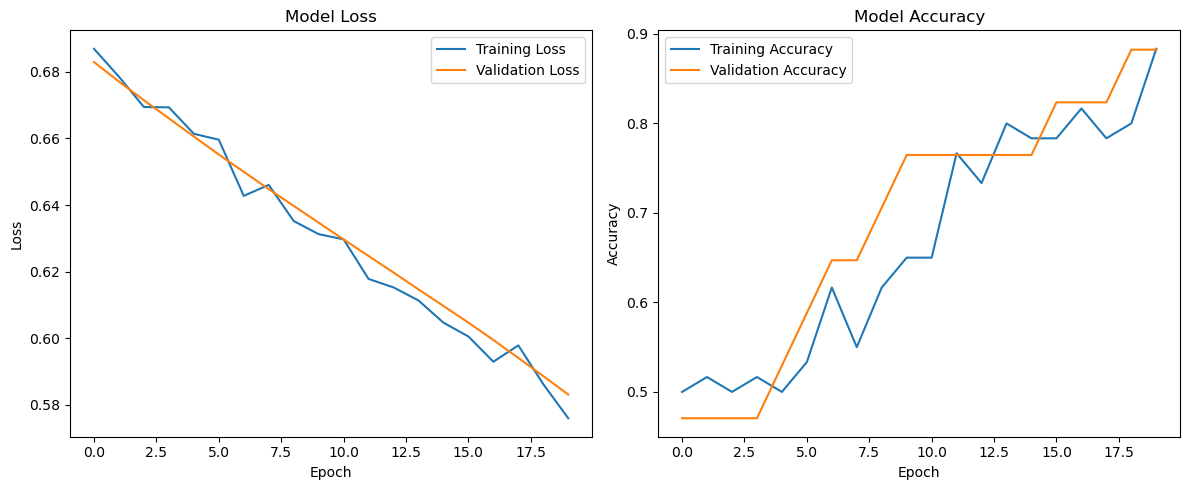

In [54]:
# Training classifier
print("Training Text Classifier...")
history_classifier = classifier.fit(
    train_inputs,
    train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [55]:
from sklearn.metrics import confusion_matrix, classification_report

1/1 [==============================] - 0s 38ms/step - loss: 0.5831 - accuracy: 0.8824 - precision_1: 1.0000 - recall_1: 0.7778 - auc_1: 1.0000
Validation Loss: 0.5831
Validation Accuracy: 0.8824
Validation Precision: 1.0000
Validation Recall: 0.7778
Validation AUC: 1.0000
1/1 [==============================] - 0s 76ms/step


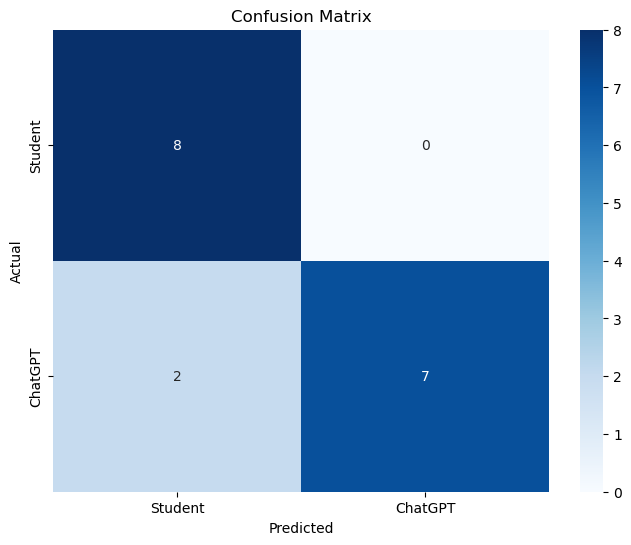


Classification Report:
              precision    recall  f1-score   support

     Student       0.80      1.00      0.89         8
     ChatGPT       1.00      0.78      0.88         9

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17

1/1 [==============================] - 0s 38ms/step - loss: 0.5575 - accuracy: 0.7778 - precision_1: 1.0000 - recall_1: 0.5000 - auc_1: 1.0000
Test Loss: 0.5575
Test Accuracy: 0.7778
Test Precision: 1.0000
Test Recall: 0.5000
Test AUC: 1.0000
1/1 [==============================] - 0s 17ms/step


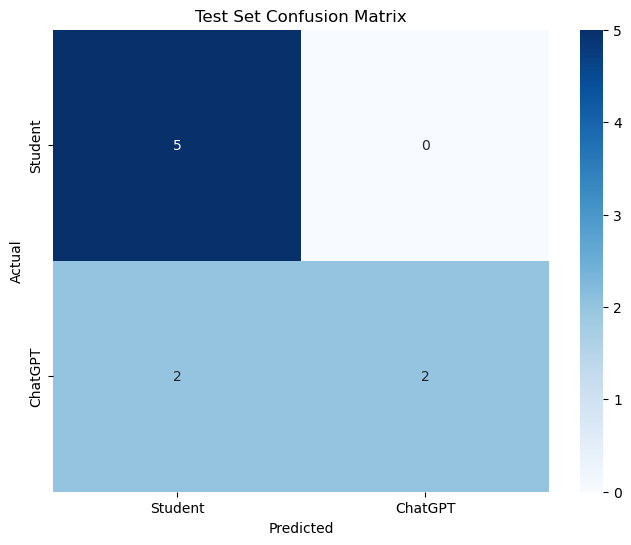


Test Set Classification Report:
              precision    recall  f1-score   support

     Student       0.71      1.00      0.83         5
     ChatGPT       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9



In [56]:
# Evaluasi model pada validation set
val_loss, val_acc, val_precision, val_recall, val_auc = classifier.evaluate(val_inputs, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Prediksi pada validation set
val_predictions = classifier.predict(val_inputs)
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(val_labels, val_predictions_binary)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions_binary, target_names=['Student', 'ChatGPT']))

# Evaluasi model pada test set
test_loss, test_acc, test_precision, test_recall, test_auc = classifier.evaluate(test_inputs, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Prediksi pada test set
test_predictions = classifier.predict(test_inputs)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Confusion matrix untuk test set
cm_test = confusion_matrix(test_labels, test_predictions_binary)

# Visualisasi confusion matrix untuk test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report untuk test set
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_predictions_binary, target_names=['Student', 'ChatGPT']))


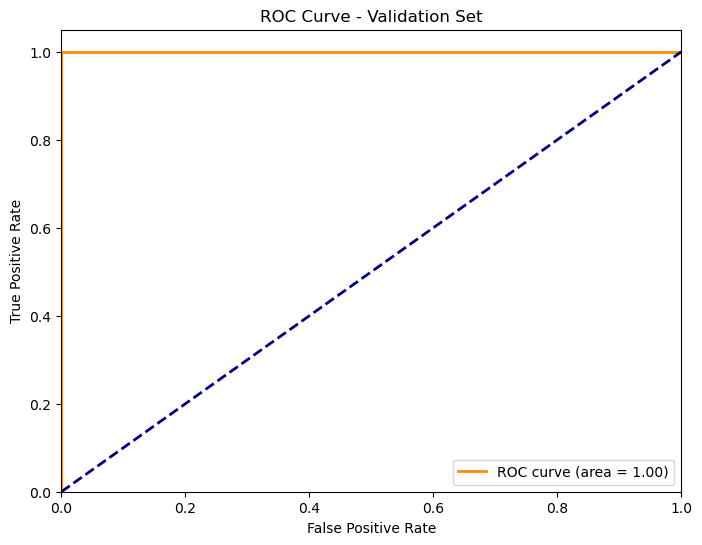

Validation AUC from ROC curve: 1.0000


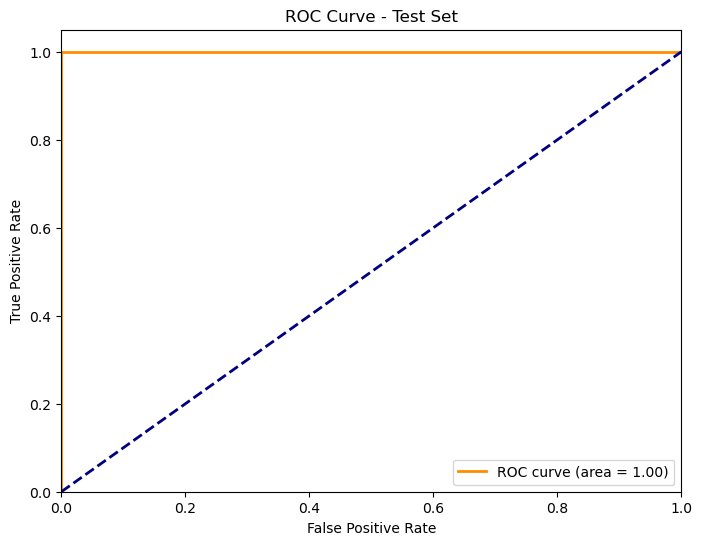

Test AUC from ROC curve: 1.0000


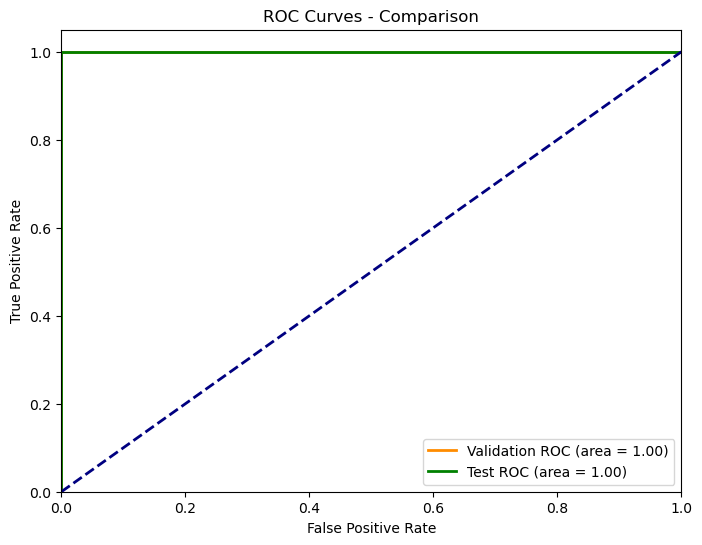

In [57]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Fungsi untuk plot ROC curve
def plot_roc_curve(labels, predictions, title):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

# Plot ROC curve untuk validation set
val_auc_score = plot_roc_curve(val_labels, val_predictions, "Validation Set")
print(f"Validation AUC from ROC curve: {val_auc_score:.4f}")

# Plot ROC curve untuk test set
test_auc_score = plot_roc_curve(test_labels, test_predictions, "Test Set")
print(f"Test AUC from ROC curve: {test_auc_score:.4f}")

# Plot kedua kurva ROC dalam satu grafik untuk perbandingan
plt.figure(figsize=(8, 6))

# Validation set
fpr_val, tpr_val, _ = roc_curve(val_labels, val_predictions)
roc_auc_val = auc(fpr_val, tpr_val)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'Validation ROC (area = {roc_auc_val:.2f})')

# Test set
fpr_test, tpr_test, _ = roc_curve(test_labels, test_predictions)
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC (area = {roc_auc_test:.2f})')

# Garis diagonal
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparison')
plt.legend(loc="lower right")
plt.show()


In [58]:
# Buat direktori jika belum ada
if not os.path.exists('saved_models_1_3'):
    os.makedirs('saved_models_1_3')

# Simpan model bi-encoder untuk Student_ChatGPT
bi_encoder_student_chatgpt.save('saved_models_1_3/bi_encoder_student_chatgpt.h5')

# Simpan model bi-encoder untuk Only_ChatGPT
bi_encoder_only_chatgpt.save('saved_models_1_3/bi_encoder_only_chatgpt.h5')

# Simpan model classifier
classifier.save('saved_models_1_3/text_classifier.h5')

# Simpan konfigurasi tokenizer
tokenizer.save_pretrained('saved_models_1_3/tokenizer')

# Simpan scaler untuk fitur stylometric
with open("saved_models_1_3/scaler_stylometric.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model dan konfigurasi berhasil disimpan!")

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model dan konfigurasi berhasil disimpan!


In [ ]:
%watermark
%watermark -iv --gpu

Last updated: 2025-04-13T19:12:19.639477+07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

transformers: 4.49.0
tensorflow  : 2.19.0
matplotlib  : 3.9.2
pandas      : 2.2.2
numpy       : 1.26.4
sklearn     : 1.5.1
seaborn     : 0.13.2
re          : 2.2.1

GPU Info: 
  GPU 0: NVIDIA GeForce GTX 1660 SUPER

